In [4]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [5]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr= None) 
    duration = librosa.get_duration(y=y, sr=sr)
    # Extract MFCCs (Mel-Frequency Cepstral Coefficients) and aggregate (mean)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    # Extract Zero-Crossing Rate and aggregate (mean)
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)
    # Extract Spectral Centroid and aggregate (mean)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_cent_mean = np.mean(spec_cent)

    features = {
            'duration': duration,
            'zcr_mean': zcr_mean,
            'spec_cent_mean': spec_cent_mean}
    
    for i, mfcc_val in enumerate(mfccs_mean):
            features[f'mfcc_mean_{i+1}'] = mfcc_val
            
    return features

In [6]:
datake = 0
folder = "E://Tugas Semester 5//Datmin 2//TM6//archive//set_b//"
all_features = []
wav_files = [f for f in os.listdir(folder) if f.endswith('.wav')]
for filename in wav_files:
        file_path = os.path.join(folder, filename)
        
        features = extract_features(file_path)
        
        if features is not None:
            features['filename'] = filename
            all_features.append(features)
    
features_df = pd.DataFrame(all_features)

## Preprocessing

In [7]:
# Isolate the feature columns for scaling (i.e., all columns except 'filename')
feature_cols = [col for col in features_df.columns if col != 'filename']
feature_matrix = features_df[feature_cols]
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)
# Create a new DataFrame for the scaled features
scaled_features_df = pd.DataFrame(scaled_features, columns=feature_cols)

# Add the filenames back for reference
scaled_features_df['filename'] = features_df['filename']

# Reorder columns so 'filename' is first
scaled_features_df = scaled_features_df[['filename'] + feature_cols]

## Clustering

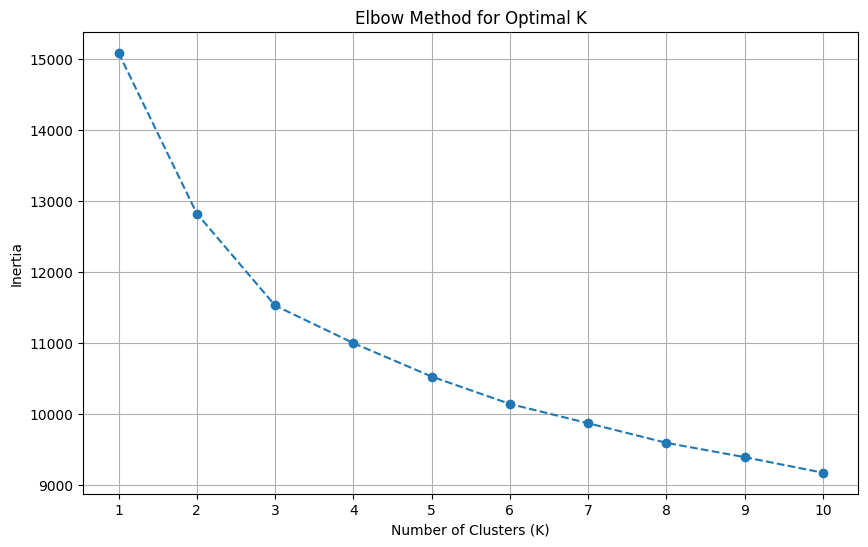

In [8]:
data = scaled_features_df[feature_cols]
inertias = []
k_range = range(1, 11)  # Checking for 1 to 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)
# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(data)

cluster_labels = kmeans.labels_
result = scaled_features_df.copy()
result['cluster'] = cluster_labels

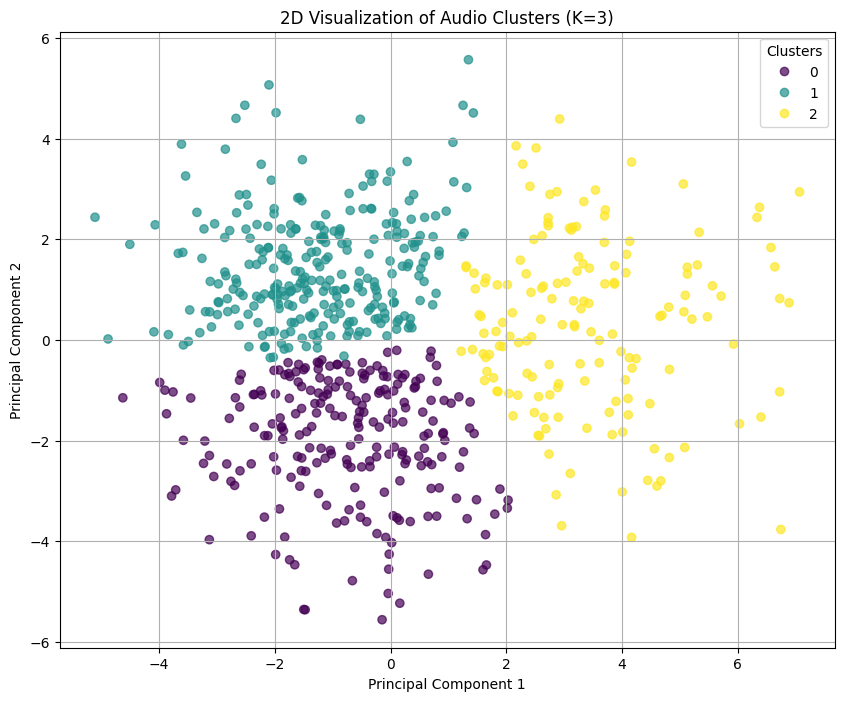

In [10]:
data1 = data.copy()
data1['cluster'] = cluster_labels
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(data1)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

plt.title(f'2D Visualization of Audio Clusters (K={3})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(3), title="Clusters")
plt.grid(True)
plt.show()

In [11]:
score = silhouette_score(data, cluster_labels)
print(f"\nSilhouette Score for K={3}: {score:.4f}")


Silhouette Score for K=3: 0.1214
